# Semantic Segmentation Lab
In this lab, you will build a deep learning network that locates a particular human target within an image.  The premise is that a quadcopter (simulated) is searching for a target, and then will follow the target once found.  It's not enough to simply say the target is present in the image in this case, but rather to know *where* in the image the target is, so that the copter can adjust its direction in order to follow.

Consequently, an image classification network is not enough to solve the problem. Intead, a semantic segmentation network is needed so that the target can be specifically located within the image.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with the dataset for this lab. If you haven't already downloaded the training and validation datasets, you can check out the README for this lab's repo for instructions as well.

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers<a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network. The following code will intoduce you to the functions that you will be using to build out your model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers. Below we have implemented two functions - one which you can call upon to build out separable convolutions or regular convolutions. Each with batch normalization and with the ReLU activation function applied to the layers. 

While we recommend the use of separable convolutions thanks to their advantages we covered in the Classroom, some of the helper code we will present for your model will require the use for regular convolutions. But we encourage you to try and experiment with each as well!

The following will help you create the encoder block and the final model for your architecture.

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function will help implement the bilinear upsampling layer. Currently, upsampling by a factor of 2 is recommended but you can try out different factors as well. You will use this to create the decoder block later!

In [7]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model<a id='build'></a>
In the following cells, we will cover how to build the model for the task at hand. 

- We will first create an Encoder Block, where you will create a separable convolution layer using an input layer and the size(depth) of the filters as your inputs.
- Next, you will create the Decoder Block, where you will create an upsampling layer using bilinear upsampling, followed by a layer concatentaion, and some separable convolution layers.
- Finally, you will combine the above two and create the model. In this step you will be able to experiment with different number of layers and filter sizes for each to build your model.

Let's cover them individually below.

### Encoder Block
Below you will create a separable convolution layer using the separable_conv2d_batchnorm() function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [3]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block, as covered in the Classroom, comprises of three steps -

- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [4]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    small_layer_up = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    conc_layers = layers.concatenate([small_layer_up,large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(conc_layers, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, you can go ahead and build your model architecture! 

There are three steps to the following:
- Add encoder blocks to build out initial set of layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add 1x1 Convolution layer using conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for upsampling and skip connections.

In [8]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    extra_layer = conv2d_batchnorm(inputs, 5, 1, 1)
    encoder1 = encoder_block(extra_layer, 10, 2)             # input, #filters, #strides , note defautl kernel_size=3
    encoder2 = encoder_block(encoder1, 20, 2)
    encoder3 = encoder_block(encoder2, 30, 2)

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_layer = conv2d_batchnorm(encoder3, 5, 1, 1)    # input, #filters, kernel_size, #strides
    
    #print(encoder1)
    #print(encoder2)
    #print(conv_layer)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder1 = decoder_block(conv_layer, encoder2, 30)   # note defautl kernel_size=3
    decoder2 = decoder_block(decoder1, encoder1, 20) 
    decoder3 = decoder_block(decoder2, extra_layer, 10) 
    
    x = decoder3


    
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x) #filters, #kernel_size

## Training<a id='training'></a>
The following cells will utilize the model you created and define an ouput layer based on the input and the number of classes.Following that you will define the hyperparameters to compile and train your model!

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 128
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [47]:
learning_rate = 0.01
batch_size = 32 #64 #32 #100 #64
num_epochs = 100
steps_per_epoch = 200 #129 #41 #200 # they recommend tot num images(4131)/batch_size
validation_steps = 50 #7 #50  # images(1184)/batch_size
workers = 2

Epoch 1/100
199/200 [============================>.] - ETA: 0s - loss: 0.0266

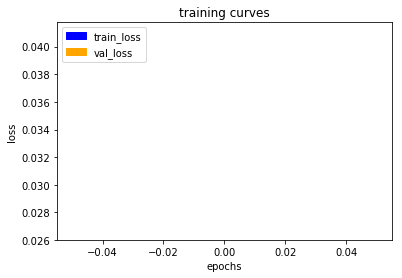

200/200 [==============================] - 37s - loss: 0.0268 - val_loss: 0.0410
Epoch 2/100
199/200 [============================>.] - ETA: 0s - loss: 0.0265

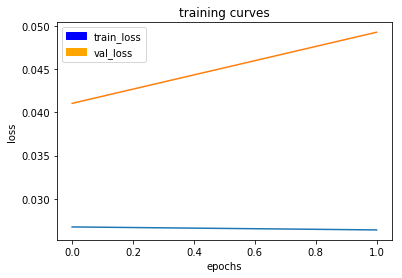

200/200 [==============================] - 36s - loss: 0.0265 - val_loss: 0.0493
Epoch 3/100
199/200 [============================>.] - ETA: 0s - loss: 0.0268

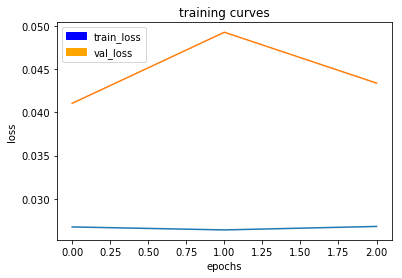

200/200 [==============================] - 36s - loss: 0.0267 - val_loss: 0.0434
Epoch 4/100
199/200 [============================>.] - ETA: 0s - loss: 0.0265

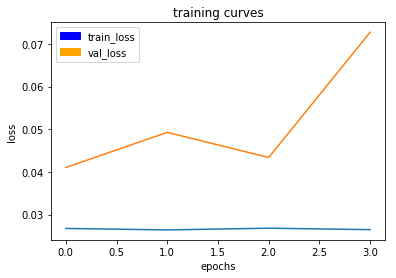

200/200 [==============================] - 36s - loss: 0.0265 - val_loss: 0.0728
Epoch 5/100
199/200 [============================>.] - ETA: 0s - loss: 0.0257

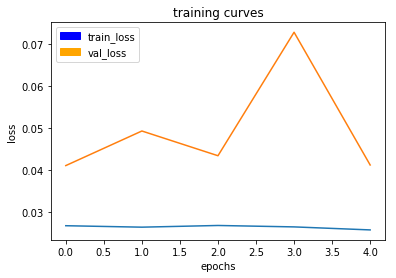

200/200 [==============================] - 36s - loss: 0.0257 - val_loss: 0.0412
Epoch 6/100
199/200 [============================>.] - ETA: 0s - loss: 0.0264

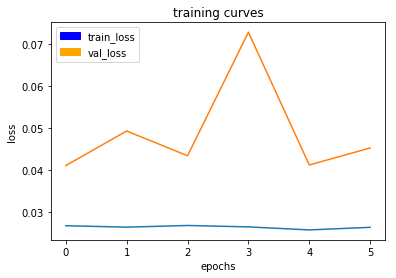

200/200 [==============================] - 36s - loss: 0.0263 - val_loss: 0.0452
Epoch 7/100
199/200 [============================>.] - ETA: 0s - loss: 0.0257

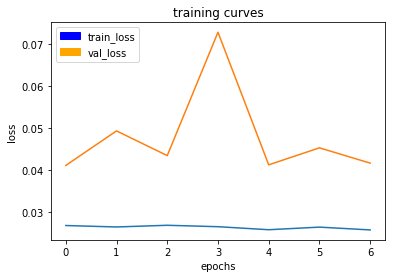

200/200 [==============================] - 36s - loss: 0.0256 - val_loss: 0.0416
Epoch 8/100
199/200 [============================>.] - ETA: 0s - loss: 0.0268

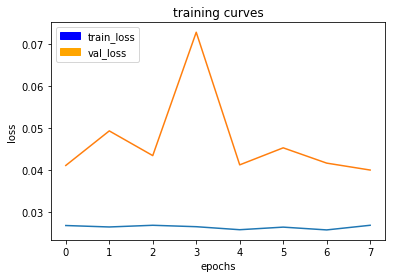

200/200 [==============================] - 36s - loss: 0.0268 - val_loss: 0.0399
Epoch 9/100
199/200 [============================>.] - ETA: 0s - loss: 0.0253

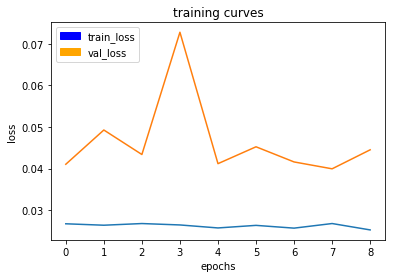

200/200 [==============================] - 36s - loss: 0.0253 - val_loss: 0.0445
Epoch 10/100
199/200 [============================>.] - ETA: 0s - loss: 0.0265

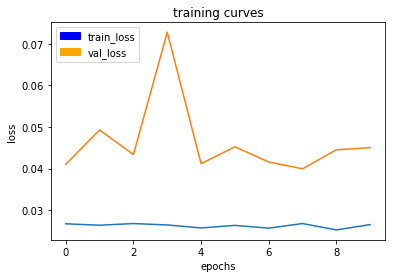

200/200 [==============================] - 37s - loss: 0.0265 - val_loss: 0.0450
Epoch 11/100
199/200 [============================>.] - ETA: 0s - loss: 0.0253

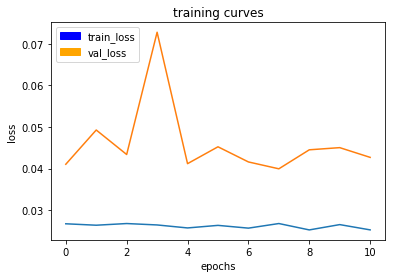

200/200 [==============================] - 36s - loss: 0.0252 - val_loss: 0.0427
Epoch 12/100
199/200 [============================>.] - ETA: 0s - loss: 0.0262

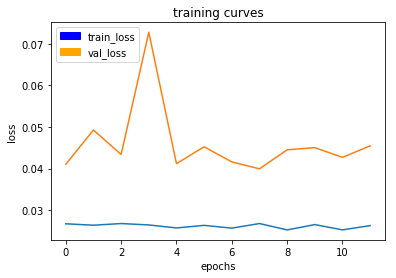

200/200 [==============================] - 36s - loss: 0.0262 - val_loss: 0.0455
Epoch 13/100
198/200 [============================>.] - ETA: 0s - loss: 0.0255

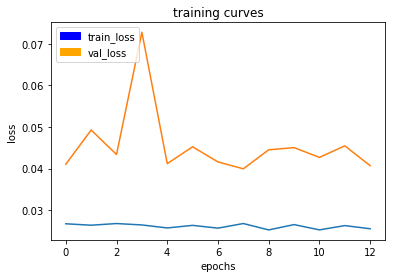

200/200 [==============================] - 36s - loss: 0.0256 - val_loss: 0.0407
Epoch 14/100
199/200 [============================>.] - ETA: 0s - loss: 0.0251

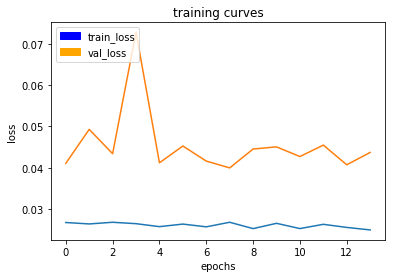

200/200 [==============================] - 36s - loss: 0.0250 - val_loss: 0.0437
Epoch 15/100
199/200 [============================>.] - ETA: 0s - loss: 0.0273

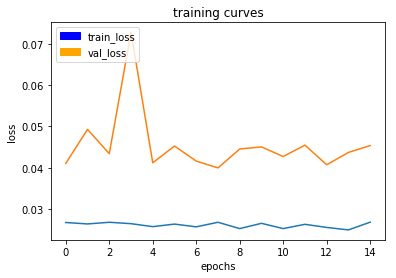

200/200 [==============================] - 37s - loss: 0.0272 - val_loss: 0.0453
Epoch 16/100
199/200 [============================>.] - ETA: 0s - loss: 0.0253

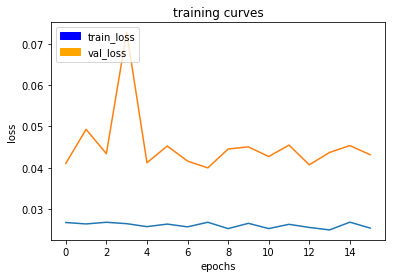

200/200 [==============================] - 37s - loss: 0.0253 - val_loss: 0.0431
Epoch 17/100
199/200 [============================>.] - ETA: 0s - loss: 0.0257

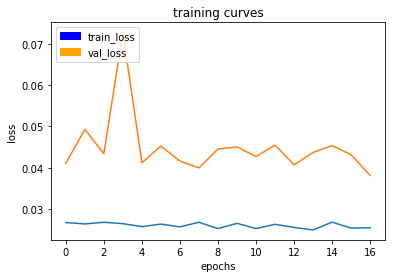

200/200 [==============================] - 36s - loss: 0.0257 - val_loss: 0.0381
Epoch 18/100
199/200 [============================>.] - ETA: 0s - loss: 0.0257

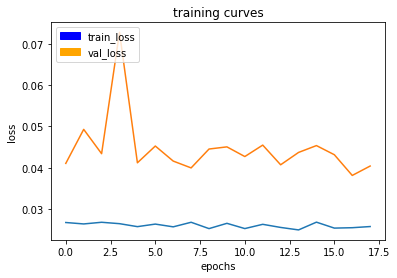

200/200 [==============================] - 36s - loss: 0.0257 - val_loss: 0.0404
Epoch 19/100
199/200 [============================>.] - ETA: 0s - loss: 0.0247

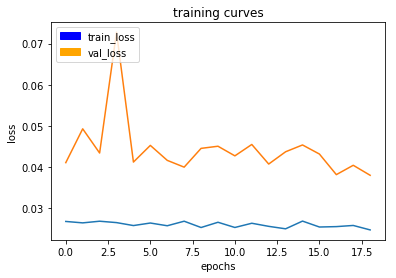

200/200 [==============================] - 36s - loss: 0.0247 - val_loss: 0.0380
Epoch 20/100
199/200 [============================>.] - ETA: 0s - loss: 0.0255

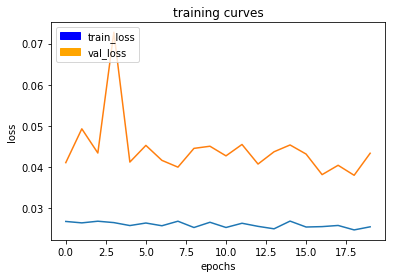

200/200 [==============================] - 37s - loss: 0.0255 - val_loss: 0.0433
Epoch 21/100
199/200 [============================>.] - ETA: 0s - loss: 0.0252

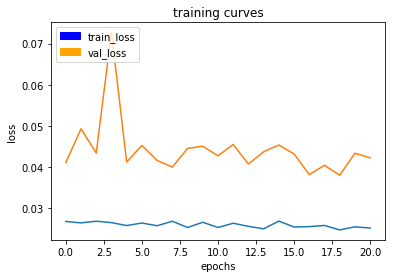

200/200 [==============================] - 36s - loss: 0.0252 - val_loss: 0.0422
Epoch 22/100
199/200 [============================>.] - ETA: 0s - loss: 0.0254

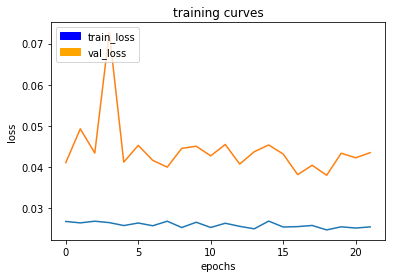

200/200 [==============================] - 36s - loss: 0.0254 - val_loss: 0.0435
Epoch 23/100
199/200 [============================>.] - ETA: 0s - loss: 0.0248

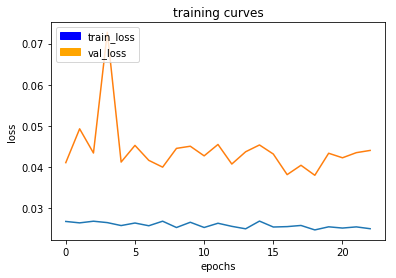

200/200 [==============================] - 36s - loss: 0.0249 - val_loss: 0.0440
Epoch 24/100
199/200 [============================>.] - ETA: 0s - loss: 0.0244

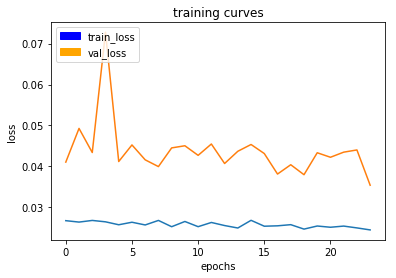

200/200 [==============================] - 36s - loss: 0.0244 - val_loss: 0.0354
Epoch 25/100
199/200 [============================>.] - ETA: 0s - loss: 0.0253

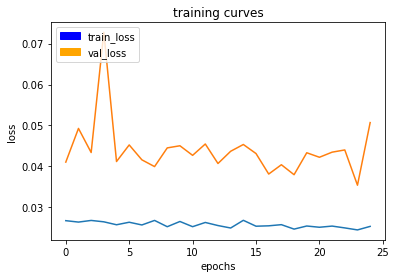

200/200 [==============================] - 36s - loss: 0.0253 - val_loss: 0.0507
Epoch 26/100
198/200 [============================>.] - ETA: 0s - loss: 0.0250

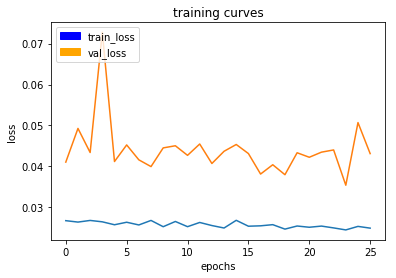

200/200 [==============================] - 36s - loss: 0.0249 - val_loss: 0.0431
Epoch 27/100
199/200 [============================>.] - ETA: 0s - loss: 0.0250

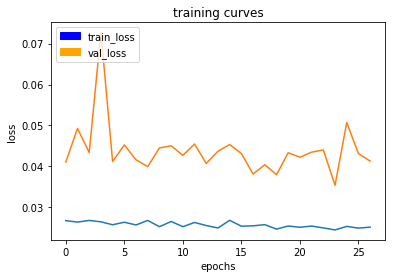

200/200 [==============================] - 36s - loss: 0.0251 - val_loss: 0.0413
Epoch 28/100
199/200 [============================>.] - ETA: 0s - loss: 0.0249

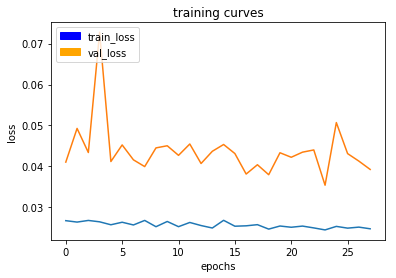

200/200 [==============================] - 36s - loss: 0.0249 - val_loss: 0.0393
Epoch 29/100
199/200 [============================>.] - ETA: 0s - loss: 0.0242

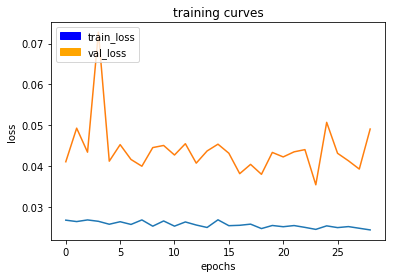

200/200 [==============================] - 36s - loss: 0.0243 - val_loss: 0.0491
Epoch 30/100
199/200 [============================>.] - ETA: 0s - loss: 0.0247

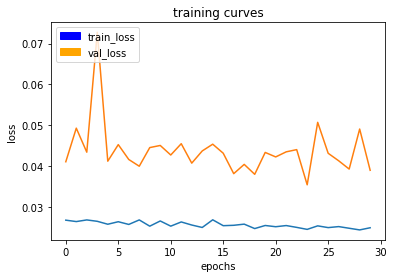

200/200 [==============================] - 36s - loss: 0.0247 - val_loss: 0.0390
Epoch 31/100
199/200 [============================>.] - ETA: 0s - loss: 0.0254

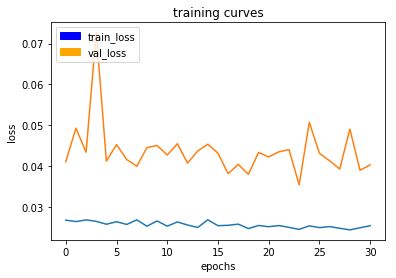

200/200 [==============================] - 37s - loss: 0.0254 - val_loss: 0.0403
Epoch 32/100
199/200 [============================>.] - ETA: 0s - loss: 0.0245

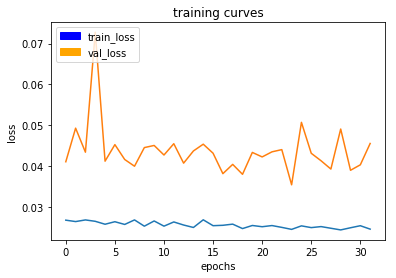

200/200 [==============================] - 36s - loss: 0.0245 - val_loss: 0.0455
Epoch 33/100
199/200 [============================>.] - ETA: 0s - loss: 0.0243

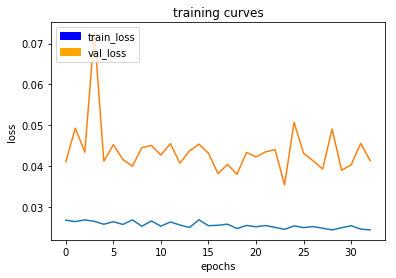

200/200 [==============================] - 37s - loss: 0.0243 - val_loss: 0.0413
Epoch 34/100
199/200 [============================>.] - ETA: 0s - loss: 0.0243

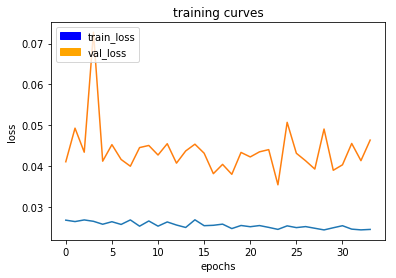

200/200 [==============================] - 37s - loss: 0.0244 - val_loss: 0.0463
Epoch 35/100
199/200 [============================>.] - ETA: 0s - loss: 0.0250

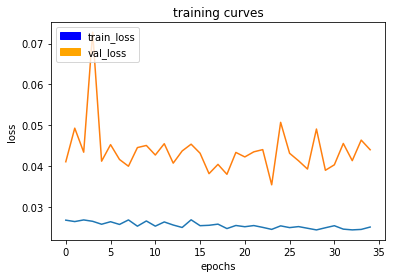

200/200 [==============================] - 36s - loss: 0.0251 - val_loss: 0.0440
Epoch 36/100
199/200 [============================>.] - ETA: 0s - loss: 0.0249

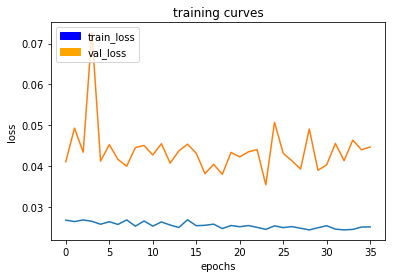

200/200 [==============================] - 36s - loss: 0.0250 - val_loss: 0.0446
Epoch 37/100
199/200 [============================>.] - ETA: 0s - loss: 0.0248

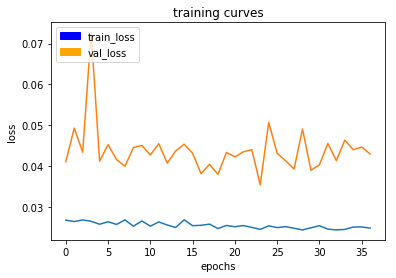

200/200 [==============================] - 36s - loss: 0.0247 - val_loss: 0.0429
Epoch 38/100
199/200 [============================>.] - ETA: 0s - loss: 0.0241

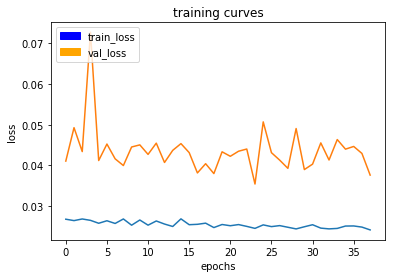

200/200 [==============================] - 36s - loss: 0.0241 - val_loss: 0.0376
Epoch 39/100
198/200 [============================>.] - ETA: 0s - loss: 0.0246

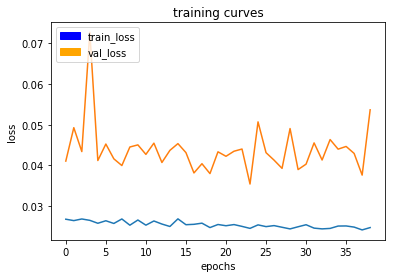

200/200 [==============================] - 36s - loss: 0.0247 - val_loss: 0.0537
Epoch 40/100
199/200 [============================>.] - ETA: 0s - loss: 0.0245

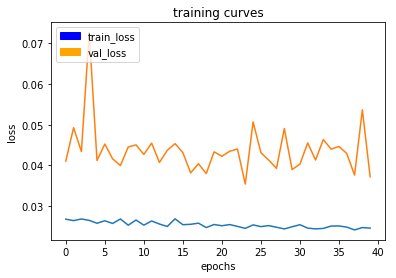

200/200 [==============================] - 37s - loss: 0.0246 - val_loss: 0.0372
Epoch 41/100
199/200 [============================>.] - ETA: 0s - loss: 0.0239

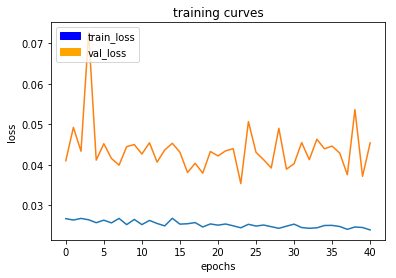

200/200 [==============================] - 36s - loss: 0.0239 - val_loss: 0.0454
Epoch 42/100
199/200 [============================>.] - ETA: 0s - loss: 0.0244

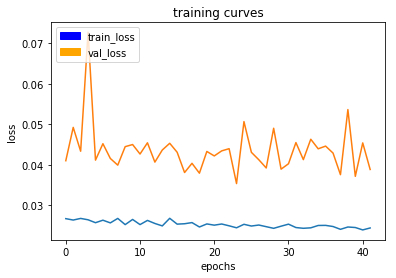

200/200 [==============================] - 37s - loss: 0.0244 - val_loss: 0.0389
Epoch 43/100
199/200 [============================>.] - ETA: 0s - loss: 0.0246

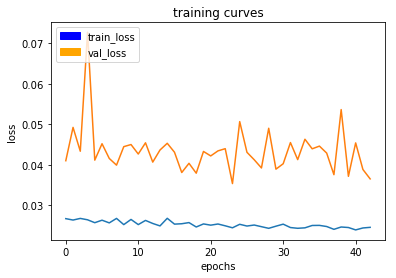

200/200 [==============================] - 36s - loss: 0.0246 - val_loss: 0.0366
Epoch 44/100
199/200 [============================>.] - ETA: 0s - loss: 0.0247

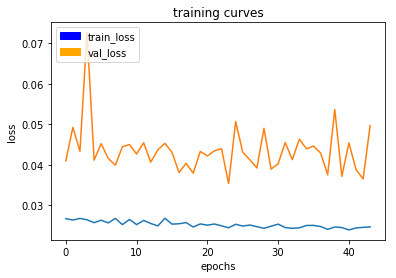

200/200 [==============================] - 36s - loss: 0.0247 - val_loss: 0.0497
Epoch 45/100
199/200 [============================>.] - ETA: 0s - loss: 0.0244

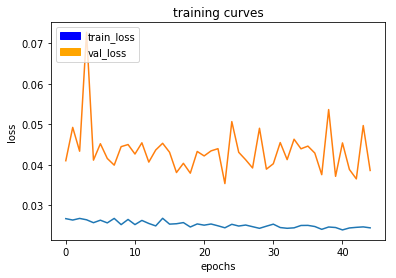

200/200 [==============================] - 37s - loss: 0.0244 - val_loss: 0.0386
Epoch 46/100
199/200 [============================>.] - ETA: 0s - loss: 0.0237

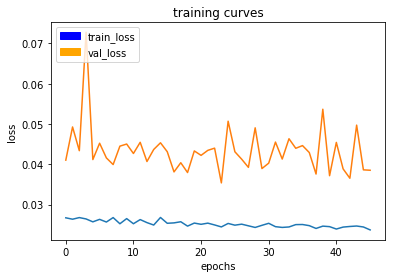

200/200 [==============================] - 36s - loss: 0.0237 - val_loss: 0.0385
Epoch 47/100
199/200 [============================>.] - ETA: 0s - loss: 0.0294

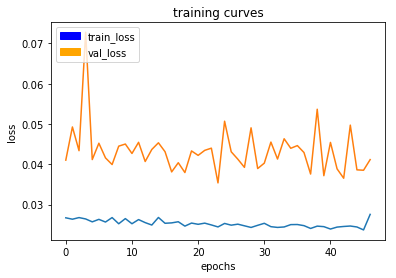

200/200 [==============================] - 36s - loss: 0.0294 - val_loss: 0.0412
Epoch 48/100
199/200 [============================>.] - ETA: 0s - loss: 0.0240

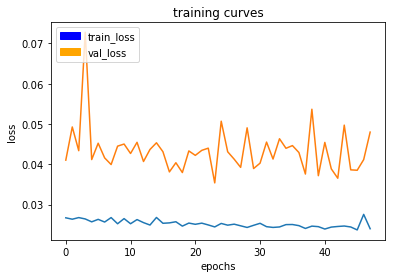

200/200 [==============================] - 36s - loss: 0.0240 - val_loss: 0.0480
Epoch 49/100
199/200 [============================>.] - ETA: 0s - loss: 0.0247

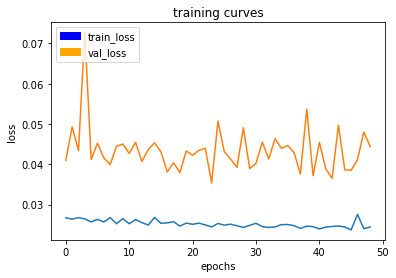

200/200 [==============================] - 36s - loss: 0.0246 - val_loss: 0.0444
Epoch 50/100
199/200 [============================>.] - ETA: 0s - loss: 0.0239

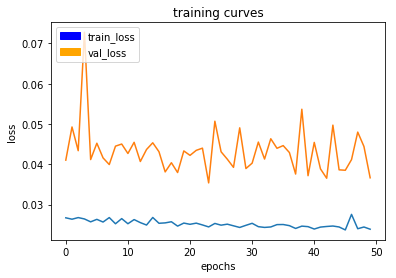

200/200 [==============================] - 37s - loss: 0.0239 - val_loss: 0.0367
Epoch 51/100
199/200 [============================>.] - ETA: 0s - loss: 0.0237

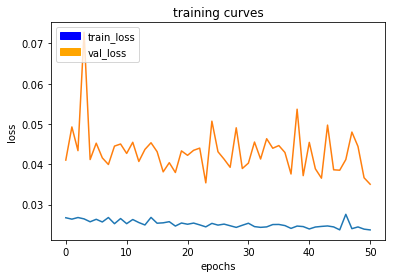

200/200 [==============================] - 36s - loss: 0.0237 - val_loss: 0.0351
Epoch 52/100
198/200 [============================>.] - ETA: 0s - loss: 0.0235

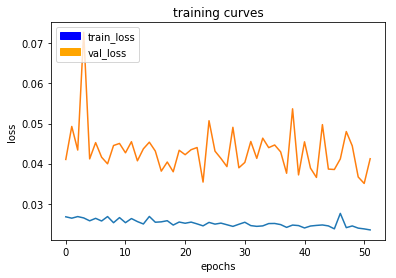

200/200 [==============================] - 36s - loss: 0.0235 - val_loss: 0.0412
Epoch 53/100
199/200 [============================>.] - ETA: 0s - loss: 0.0229

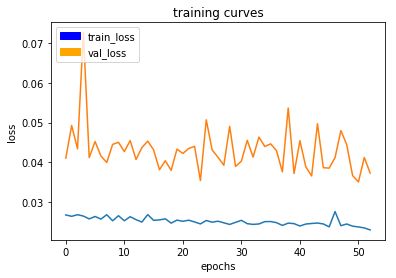

200/200 [==============================] - 36s - loss: 0.0229 - val_loss: 0.0373
Epoch 54/100
199/200 [============================>.] - ETA: 0s - loss: 0.0244

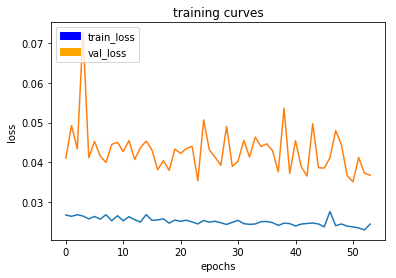

200/200 [==============================] - 36s - loss: 0.0244 - val_loss: 0.0367
Epoch 55/100
199/200 [============================>.] - ETA: 0s - loss: 0.0236

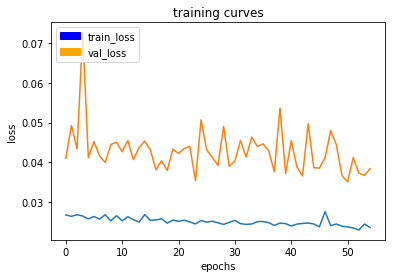

200/200 [==============================] - 36s - loss: 0.0236 - val_loss: 0.0384
Epoch 56/100
199/200 [============================>.] - ETA: 0s - loss: 0.0240

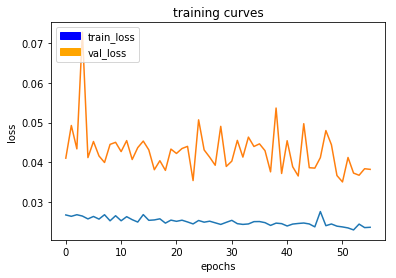

200/200 [==============================] - 36s - loss: 0.0240 - val_loss: 0.0382
Epoch 57/100
199/200 [============================>.] - ETA: 0s - loss: 0.0240

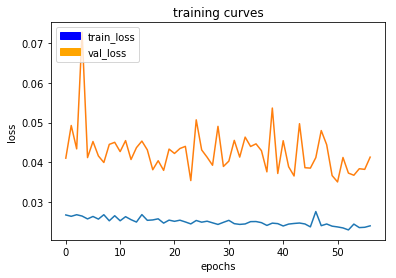

200/200 [==============================] - 37s - loss: 0.0241 - val_loss: 0.0413
Epoch 58/100
199/200 [============================>.] - ETA: 0s - loss: 0.0233

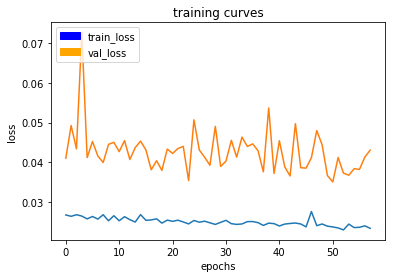

200/200 [==============================] - 36s - loss: 0.0233 - val_loss: 0.0431
Epoch 59/100
199/200 [============================>.] - ETA: 0s - loss: 0.0236

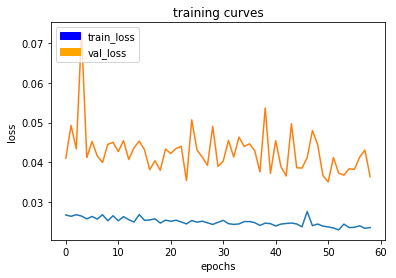

200/200 [==============================] - 36s - loss: 0.0236 - val_loss: 0.0364
Epoch 60/100
199/200 [============================>.] - ETA: 0s - loss: 0.0243

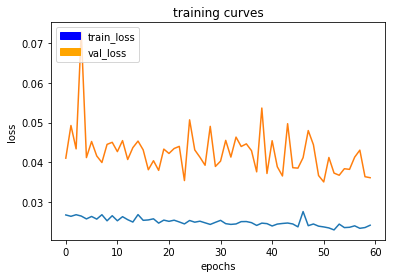

200/200 [==============================] - 37s - loss: 0.0243 - val_loss: 0.0361
Epoch 61/100
199/200 [============================>.] - ETA: 0s - loss: 0.0233

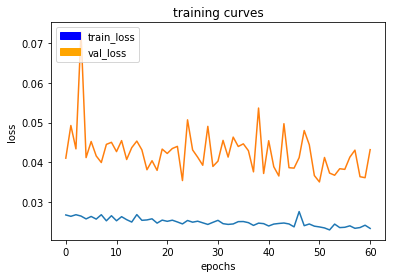

200/200 [==============================] - 36s - loss: 0.0233 - val_loss: 0.0432
Epoch 62/100
199/200 [============================>.] - ETA: 0s - loss: 0.0232

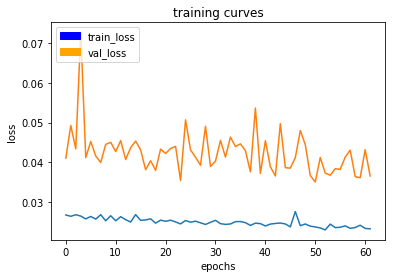

200/200 [==============================] - 36s - loss: 0.0232 - val_loss: 0.0365
Epoch 63/100
199/200 [============================>.] - ETA: 0s - loss: 0.0236

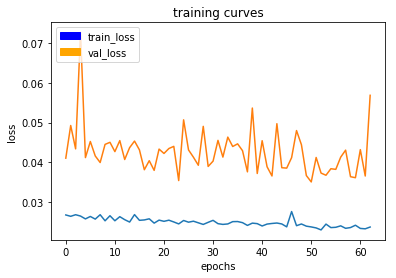

200/200 [==============================] - 36s - loss: 0.0236 - val_loss: 0.0569
Epoch 64/100
199/200 [============================>.] - ETA: 0s - loss: 0.0233

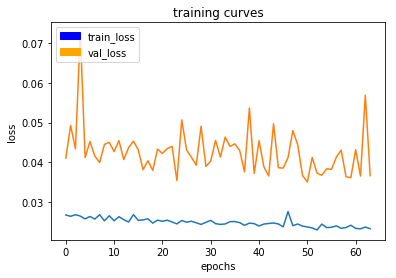

200/200 [==============================] - 36s - loss: 0.0233 - val_loss: 0.0366
Epoch 65/100
198/200 [============================>.] - ETA: 0s - loss: 0.0238

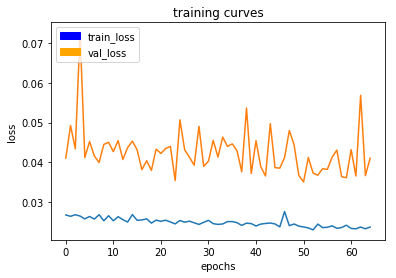

200/200 [==============================] - 36s - loss: 0.0237 - val_loss: 0.0410
Epoch 66/100
199/200 [============================>.] - ETA: 0s - loss: 0.0253

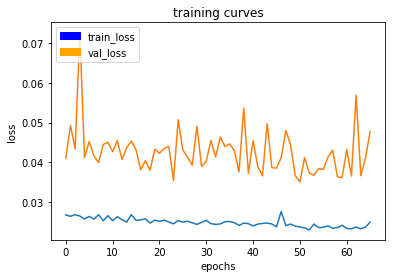

200/200 [==============================] - 36s - loss: 0.0253 - val_loss: 0.0478
Epoch 67/100
199/200 [============================>.] - ETA: 0s - loss: 0.0244

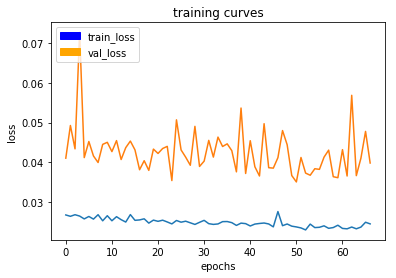

200/200 [==============================] - 36s - loss: 0.0244 - val_loss: 0.0398
Epoch 68/100
199/200 [============================>.] - ETA: 0s - loss: 0.0236

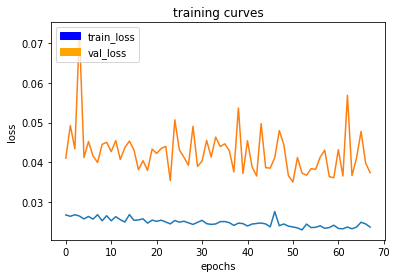

200/200 [==============================] - 36s - loss: 0.0236 - val_loss: 0.0374
Epoch 69/100
199/200 [============================>.] - ETA: 0s - loss: 0.0231

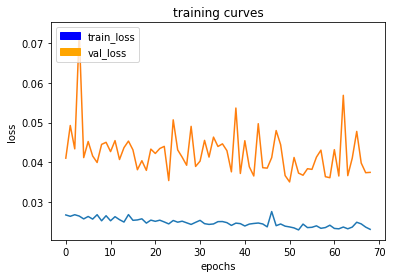

200/200 [==============================] - 37s - loss: 0.0231 - val_loss: 0.0375
Epoch 70/100
199/200 [============================>.] - ETA: 0s - loss: 0.0231

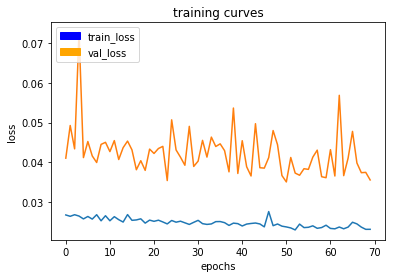

200/200 [==============================] - 36s - loss: 0.0231 - val_loss: 0.0355
Epoch 71/100
199/200 [============================>.] - ETA: 0s - loss: 0.0236

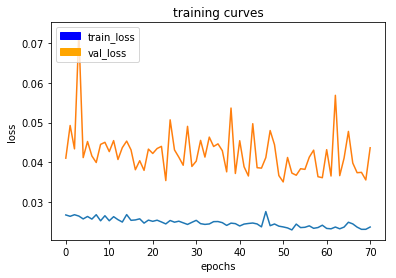

200/200 [==============================] - 36s - loss: 0.0236 - val_loss: 0.0437
Epoch 72/100
199/200 [============================>.] - ETA: 0s - loss: 0.0228

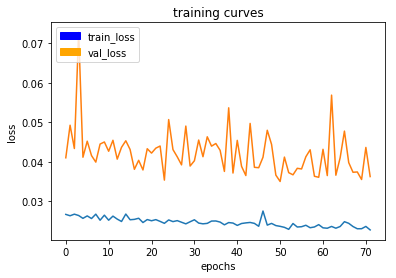

200/200 [==============================] - 36s - loss: 0.0228 - val_loss: 0.0363
Epoch 73/100
199/200 [============================>.] - ETA: 0s - loss: 0.0234

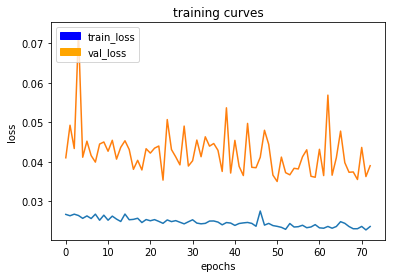

200/200 [==============================] - 36s - loss: 0.0237 - val_loss: 0.0390
Epoch 74/100
199/200 [============================>.] - ETA: 0s - loss: 0.0232

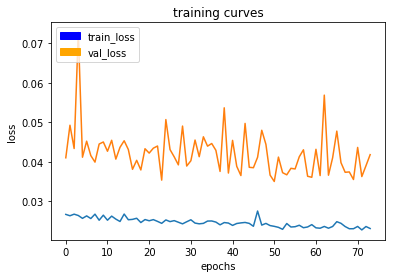

200/200 [==============================] - 36s - loss: 0.0232 - val_loss: 0.0418
Epoch 75/100
199/200 [============================>.] - ETA: 0s - loss: 0.0239

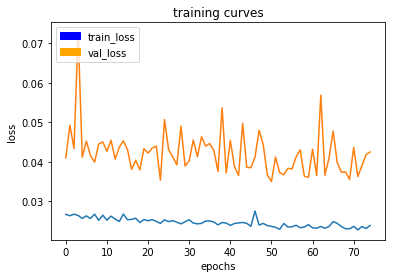

200/200 [==============================] - 36s - loss: 0.0239 - val_loss: 0.0425
Epoch 76/100
199/200 [============================>.] - ETA: 0s - loss: 0.0231

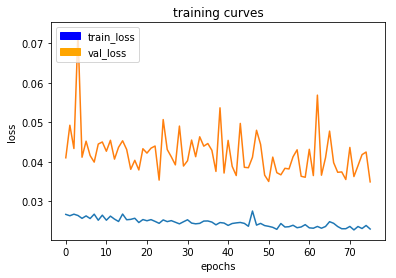

200/200 [==============================] - 37s - loss: 0.0230 - val_loss: 0.0350
Epoch 77/100
199/200 [============================>.] - ETA: 0s - loss: 0.0240

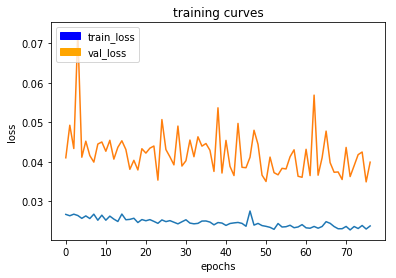

200/200 [==============================] - 36s - loss: 0.0240 - val_loss: 0.0399
Epoch 78/100
198/200 [============================>.] - ETA: 0s - loss: 0.0231

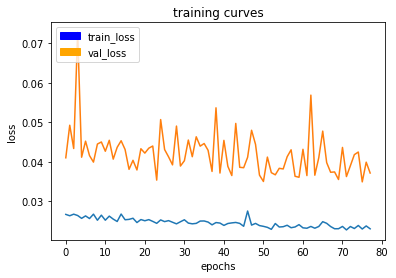

200/200 [==============================] - 36s - loss: 0.0232 - val_loss: 0.0372
Epoch 79/100
199/200 [============================>.] - ETA: 0s - loss: 0.0234

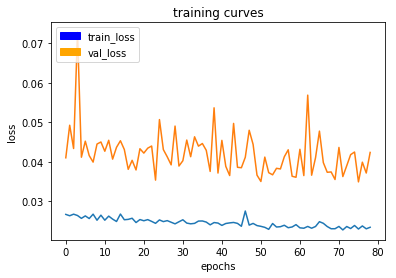

200/200 [==============================] - 36s - loss: 0.0234 - val_loss: 0.0424
Epoch 80/100
199/200 [============================>.] - ETA: 0s - loss: 0.0228

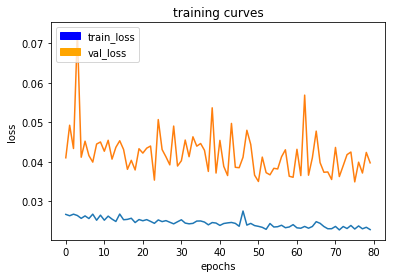

200/200 [==============================] - 36s - loss: 0.0228 - val_loss: 0.0398
Epoch 81/100
199/200 [============================>.] - ETA: 0s - loss: 0.0232

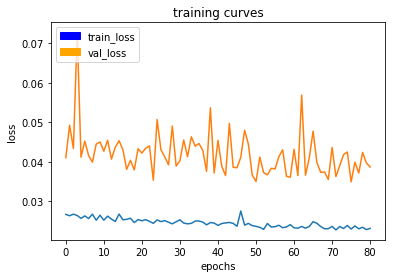

200/200 [==============================] - 36s - loss: 0.0232 - val_loss: 0.0387
Epoch 82/100
199/200 [============================>.] - ETA: 0s - loss: 0.0228

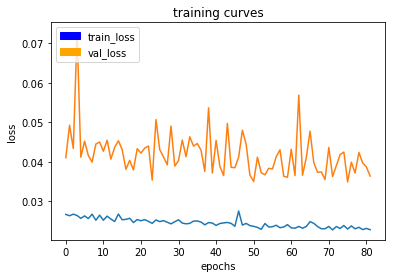

200/200 [==============================] - 36s - loss: 0.0228 - val_loss: 0.0364
Epoch 83/100
199/200 [============================>.] - ETA: 0s - loss: 0.0226

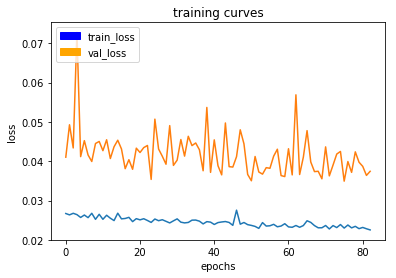

200/200 [==============================] - 36s - loss: 0.0226 - val_loss: 0.0375
Epoch 84/100
199/200 [============================>.] - ETA: 0s - loss: 0.0232

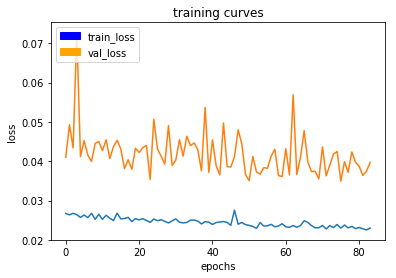

200/200 [==============================] - 36s - loss: 0.0231 - val_loss: 0.0397
Epoch 85/100
199/200 [============================>.] - ETA: 0s - loss: 0.0227

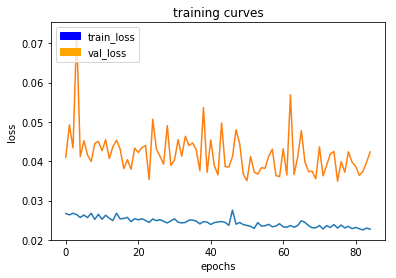

200/200 [==============================] - 36s - loss: 0.0227 - val_loss: 0.0424
Epoch 86/100
199/200 [============================>.] - ETA: 0s - loss: 0.0235

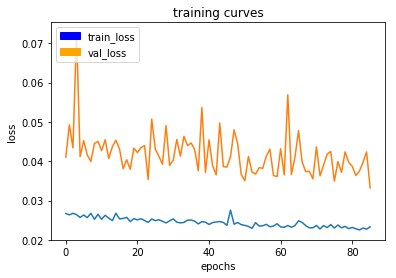

200/200 [==============================] - 36s - loss: 0.0234 - val_loss: 0.0333
Epoch 87/100
199/200 [============================>.] - ETA: 0s - loss: 0.0232

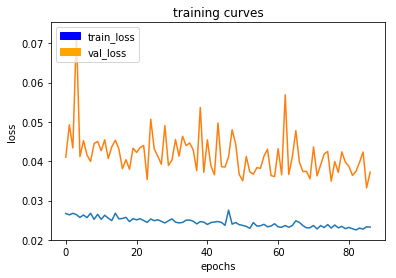

200/200 [==============================] - 36s - loss: 0.0233 - val_loss: 0.0372
Epoch 88/100
199/200 [============================>.] - ETA: 0s - loss: 0.0242

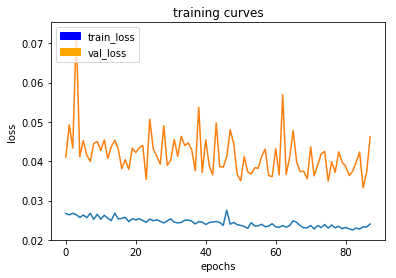

200/200 [==============================] - 36s - loss: 0.0241 - val_loss: 0.0462
Epoch 89/100
199/200 [============================>.] - ETA: 0s - loss: 0.0227

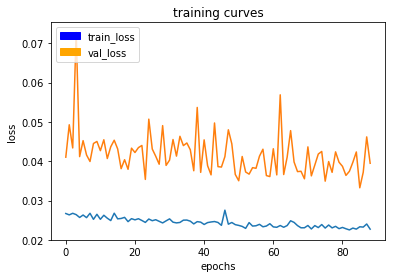

200/200 [==============================] - 36s - loss: 0.0227 - val_loss: 0.0395
Epoch 90/100
199/200 [============================>.] - ETA: 0s - loss: 0.0228

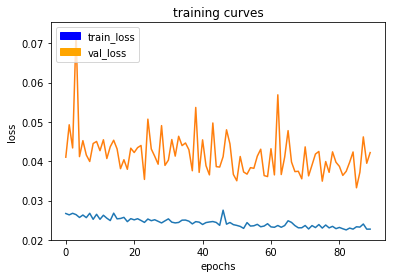

200/200 [==============================] - 36s - loss: 0.0227 - val_loss: 0.0422
Epoch 91/100
198/200 [============================>.] - ETA: 0s - loss: 0.0229

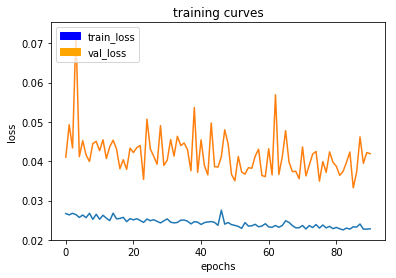

200/200 [==============================] - 36s - loss: 0.0229 - val_loss: 0.0419
Epoch 92/100
199/200 [============================>.] - ETA: 0s - loss: 0.0228

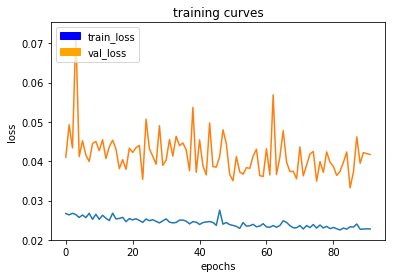

200/200 [==============================] - 36s - loss: 0.0228 - val_loss: 0.0417
Epoch 93/100
199/200 [============================>.] - ETA: 0s - loss: 0.0236

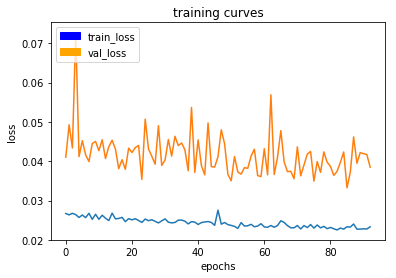

200/200 [==============================] - 36s - loss: 0.0236 - val_loss: 0.0385
Epoch 94/100
199/200 [============================>.] - ETA: 0s - loss: 0.0228

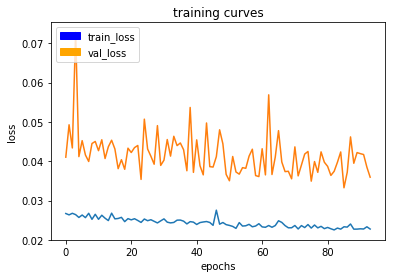

200/200 [==============================] - 37s - loss: 0.0228 - val_loss: 0.0360
Epoch 95/100
199/200 [============================>.] - ETA: 0s - loss: 0.0225

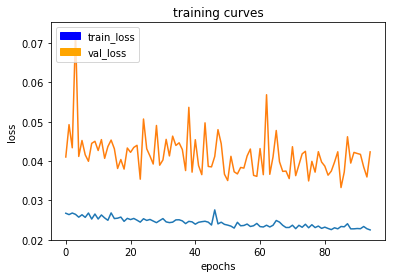

200/200 [==============================] - 36s - loss: 0.0225 - val_loss: 0.0423
Epoch 96/100
199/200 [============================>.] - ETA: 0s - loss: 0.0224

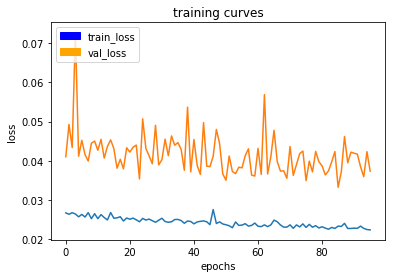

200/200 [==============================] - 36s - loss: 0.0224 - val_loss: 0.0374
Epoch 97/100
199/200 [============================>.] - ETA: 0s - loss: 0.0235

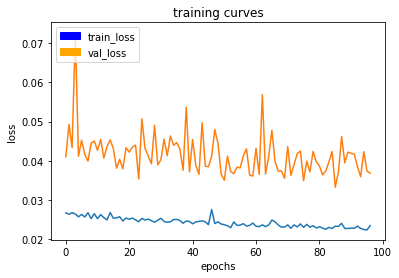

200/200 [==============================] - 36s - loss: 0.0235 - val_loss: 0.0369
Epoch 98/100
199/200 [============================>.] - ETA: 0s - loss: 0.0231

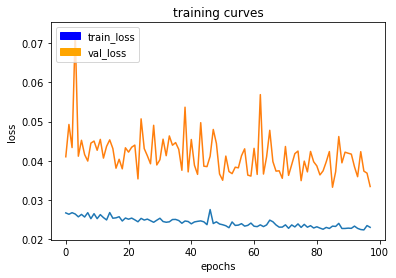

200/200 [==============================] - 36s - loss: 0.0231 - val_loss: 0.0335
Epoch 99/100
199/200 [============================>.] - ETA: 0s - loss: 0.0227

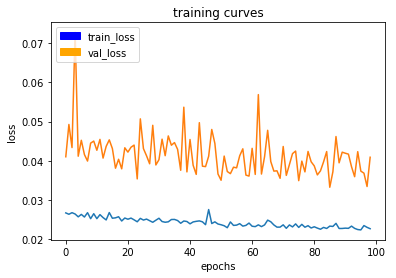

200/200 [==============================] - 36s - loss: 0.0227 - val_loss: 0.0409
Epoch 100/100
199/200 [============================>.] - ETA: 0s - loss: 0.0232

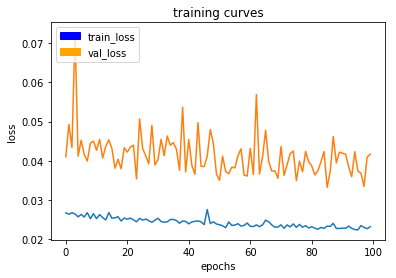

200/200 [==============================] - 36s - loss: 0.0232 - val_loss: 0.0417


In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [49]:
# Save your trained model weights
weight_file_name = 'model_weights_11' #'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction<a id='prediction'></a>

In [ ]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

In [50]:
# generate predictions, save in the runs, directory.
run_number = 'run11'
validation_path, output_path = model_tools.write_predictions_grade_set(model,run_number,'validation')

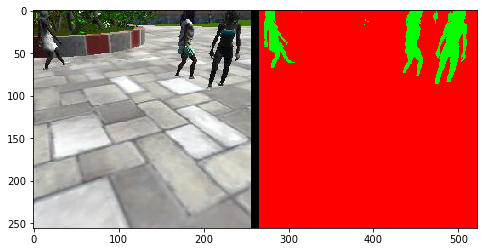

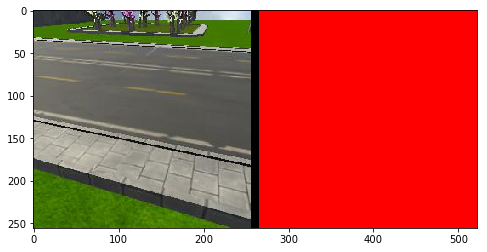

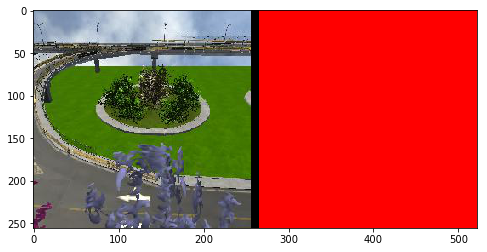

In [51]:
# take a look at predictions
# validation_path = 'validation'
im_files = plotting_tools.get_im_file_sample(run_number,validation_path) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation<a id='evaluation'></a>
Let's evaluate your model!

In [52]:
scoring_utils.score_run(validation_path, output_path)

number of validation samples intersection over the union evaulated on 1184
average intersection over union for background is 0.9906990633690538
average intersection over union for other people is 0.35576806604600353
average intersection over union for hero is 0.15017616827591712
global average intersection over union is 0.49888109923032475
